# Stage-Two Filamentary Coil Optimization
This notebook will show how to use DESC to perform stage two coil optimization with filamentary coils of differing parameterizations, such as Fourier in terms of arbitrary angle (as pioneered by [FOCUS][1]) or planar coils described in terms of the coil center, normal to the plane, and a Fourier series describing the radius of the coil in that plane. We will first find a coilset for the precise QA ([Landreman & Paul 2022][2]) vacuum equilibrium, starting from an initial coilset composed of circular planar coils, with only coils parameterized by a Fourier series in an arbitrary curve parameter. A second coil optimization will be performed for a W7-X-like finite beta equilibrium using a coilset composed of various coil parameterizations. Once optimized, the normal field error will be assessed, and for the vacuum equilibrium, field line tracing will be performed to compare the Poincare trace to the equilibrium flux surfaces.


[1]: <https://doi.org/10.1088/1741-4326/aa8e0a> "Zhu, C., Hudson, S. R., Song, Y. & Wan, Y. New method to design stellarator coils without the winding surface. Nucl. Fusion 58, 016008 (2018)."

[2]: <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.035001> "M. Landreman. & E. Paul. 2022 Physical Review Letters"

In [1]:
# uncomment these two lines if using a gpu for a speedup
from desc import set_device
set_device("gpu")

In [4]:
import numpy as np
from desc.coils import CoilSet, FourierPlanarCoil
import desc.examples
from desc.equilibrium import Equilibrium
from desc.plotting import plot_surfaces, plot_2d, plot_3d, plot_coils
from desc.grid import LinearGrid
from desc.coils import MixedCoilSet
from desc.objectives import (
    ObjectiveFunction,
    CoilCurvature,
    CoilLength,
    CoilTorsion,
    CoilSetMinDistance,
    PlasmaCoilSetMinDistance,
    QuadraticFlux,
    ToroidalFlux,
    FixCoilCurrent,
    FixParameters,
    QuasisymmetryTwoTerm,
    AspectRatio,
    ForceBalance,
    VacuumBoundaryError,
    BoundaryError,
    FixPsi,
    FixPressure,
    FixCurrent,
    FixBoundaryR,
    FixBoundaryZ
)
from desc.optimize import Optimizer
from desc.magnetic_fields import field_line_integrate
from desc.integrals.singularities import compute_B_plasma
import time
import plotly.express as px
import plotly.io as pio
from desc.io import load
# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "png"

## Coil Optimization Metrics

Two main figures of merit regarding the quality of the coil optimization in recreating the equilibrium are the average normalized magnetic field and Poincare plot from the coils. The average normalized magnetic field is a measure of how well the coils' field (plus the plasma field if it is finite beta) recreates last closed flux surface of the target equilibrium and is given as 
$$
\frac{\left<|\mathbf{B}_{\text{total}}\cdot \mathbf{\hat{n}}|\right>}{\left<|\mathbf{B}_{\text{total}}|\right>}
$$
where $\mathbf{\hat{n}}$ is the normal vector to the equilibrium's last closed flux surface and $\mathbf{B}_{\text{total}} = \mathbf{B}_{\text{coils}} + \mathbf{B}_{\text{plasma currents}}$. Field traces are also significant for vacuum equilibria because they visually show the quality of the coil field in recreating the equilibrium vacuum flux surfaces.

These two metrics are calculated in functions below.

In [5]:
def compute_average_normalized_field(field, eq, vacuum=False):
    grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
    Bn, surf_coords = field.compute_Bnormal(eq, eval_grid=grid)
    normalizing_field_vec = field.compute_magnetic_field(surf_coords)
    if not vacuum:
        # add plasma field to the normalizing field
        normalizing_field_vec += compute_B_plasma(eq, eval_grid=grid)
    normalizing_field = np.mean(np.linalg.norm(normalizing_field_vec, axis=1))
    return np.mean(np.abs(Bn)) / normalizing_field


def plot_field_lines(field, eq):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
    r0 = eq.compute("R", grid=grid_trace)["R"]
    z0 = eq.compute("Z", grid=grid_trace)["Z"]
    fig, ax = desc.plotting.plot_surfaces(eq)
    fig, ax = desc.plotting.poincare_plot(
        field,
        r0,
        z0,
        NFP=eq.NFP,
        ax=ax,
        color="k",
        size=1,
    )
    return fig, ax

## Vacuum

We will be focusing on optimizing coils with the vacuum precise QA as the target equilibrium.

In [6]:
eq = load("desc_initial_fixed_bdry_solve_final.h5")

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

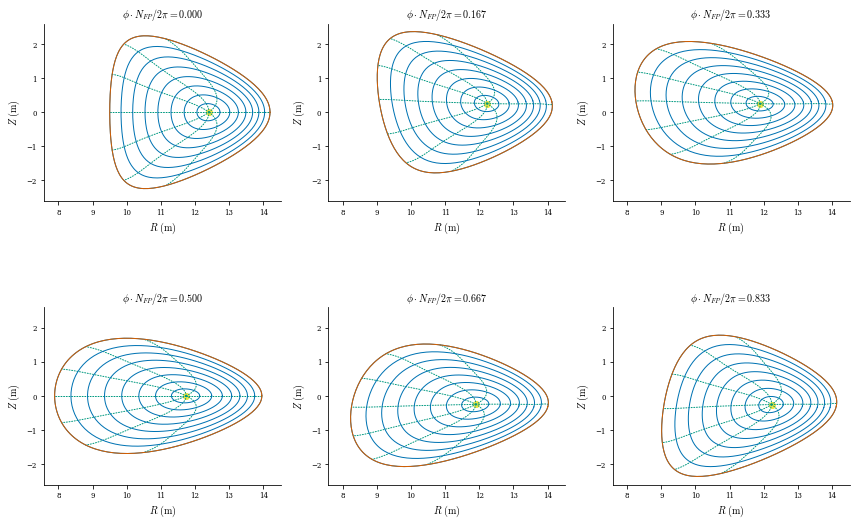

In [7]:
plot_surfaces(eq)

### Make initial coilset

We start by creating planar coils centered and aligned with the magnetic axis, equally spaced in the toroidal angle phi. Note that the coil positions are chosen to avoid the symmetry planes. We then convert the planar coils to the FourierXYZ parameterization. There are only 3 "unique" coils, and the full CoilSet accounts for the other "virtual" coils from field period and stellarator symmetry. 

In [8]:
minor_radius = eq.compute("a")["a"]
offset = 0.3
num_coils = 3  # coils per half field period
coilset1 = load("fitted_coilset_n11.h5")

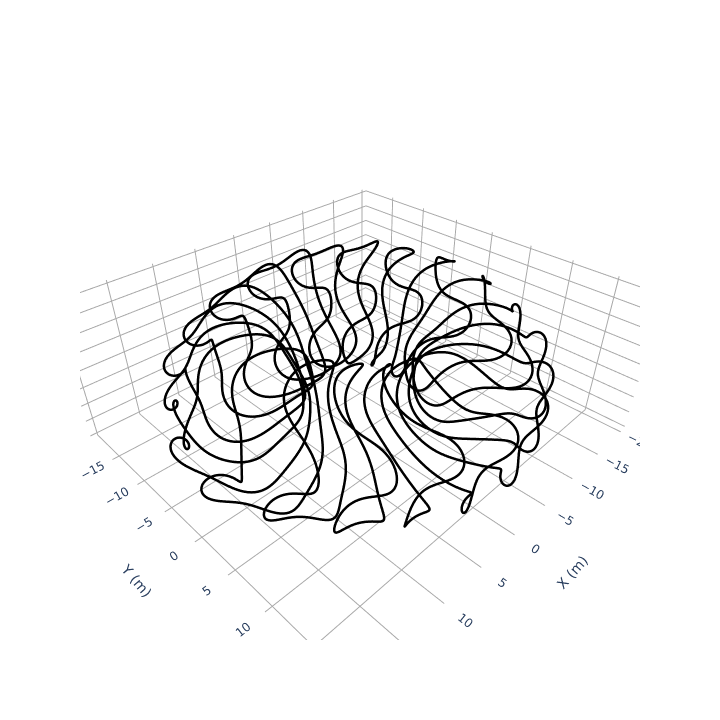

In [9]:
coilset = CoilSet(coilset1[0:round(len(coilset1)/eq.NFP/2)], NFP=eq.NFP,sym=True)
# visualize the initial coilset
# we use a smaller than usual plot grid to reduce memory of the notebook file
plot_grid = LinearGrid(M=20, N=40, NFP=1, endpoint=True)
# fig = plot_3d(eq, "|B|", grid=plot_grid)
fig = plot_coils(coilset)#, fig=fig)
fig.show()

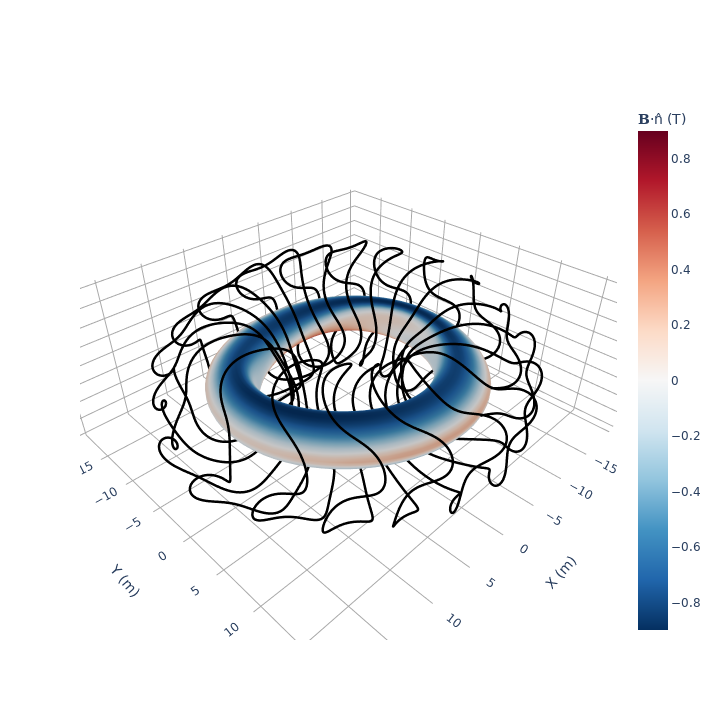

In [10]:
fig = plot_3d(eq, "B*n", grid=plot_grid,field=coilset)
fig = plot_coils(coilset, fig=fig)
fig.show()

### Optimizing a `FourierXYZCoil` coil set

In [14]:
import jax
jax.clear_caches()
# number of points used to discretize coils. This could be different for each objective
# (eg if you want higher resolution for some calculations), but we'll use the same for all of them
coil_grid = LinearGrid(N=150)
# similarly define a grid on the plasma surface where B*n errors will be evaluated
plasma_grid = LinearGrid(M=35, N=35, NFP=eq.NFP, sym=False)

In [15]:
objective=PlasmaCoilSetMinDistance(
            eq,
            coilset,
            # in normalized units, want plasma-coil distance to be at least 25% of minor radius
            bounds=(1.3, np.inf),
            normalize_target=False,  # we're giving bounds in normalized units
            plasma_grid=plasma_grid,
            coil_grid=coil_grid,
            eq_fixed=True,  # Fix the equilibrium. For single stage optimization, this would be False
            weight=25,
        )
objective.build()
print(objective.compute_scaled_error(coilset.params_dict))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
objective=CoilSetMinDistance(
            coilset,
            # in normalized units, want coil-coil distance to be at least 10% of minor radius
            bounds=(0.12, np.inf),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=100,
        )
objective.build()
print(objective.compute_scaled_error(coilset.params_dict))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
objective=CoilCurvature(
            coilset,
            # this uses signed curvature, depending on whether it curves towards
            # or away from the centroid of the curve, with a circle having positive curvature.
            # We give the bounds normalized units, curvature of approx 1 means circular,
            # so we allow them to be a bit more strongly shaped
            bounds=(-3.5, 4),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=100,
        )
objective.build()
print(objective.compute_scaled_error(coilset.params_dict))

Precomputing transforms
[0. 0. 0. ... 0. 0. 0.]


In [18]:
objective=CoilLength(
            coilset,
            bounds=(0, 7 * np.pi * (minor_radius + offset)),
            normalize_target=True,  # target length is in meters, not normalized
            grid=coil_grid,
            weight=1,
        )
objective.build()
print(objective.compute_scaled_error(coilset.params_dict))

Precomputing transforms
[0. 0. 0. 0. 0.]


In [19]:
# define our objective function
obj = ObjectiveFunction(
    (
        QuadraticFlux(
            eq,
            field=coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            weight=100,
        ),
        CoilSetMinDistance(
            coilset,
            # in normalized units, want coil-coil distance to be at least 10% of minor radius
            bounds=(0.1, np.inf),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=100,
        ),
        PlasmaCoilSetMinDistance(
            eq,
            coilset,
            # in normalized units, want plasma-coil distance to be at least 25% of minor radius
            bounds=(1.0, np.inf),
            normalize_target=False,  # we're giving bounds in normalized units
            plasma_grid=plasma_grid,
            coil_grid=coil_grid,
            eq_fixed=True,  # Fix the equilibrium. For single stage optimization, this would be False
            weight=100,
        ),
        CoilCurvature(
            coilset,
            # this uses signed curvature, depending on whether it curves towards
            # or away from the centroid of the curve, with a circle having positive curvature.
            # We give the bounds normalized units, curvature of approx 1 means circular,
            # so we allow them to be a bit more strongly shaped
            bounds=(-4, 4),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=100,
        ),
        CoilLength(
            coilset,
            bounds=(0, 6.5 * np.pi * (minor_radius + offset)),
            normalize_target=True,  # target length is in meters, not normalized
            grid=coil_grid,
            weight=1,
        ),
    )
)

## define our constraints

# Pick an optimizer. For this problem with only linear constraints we can use a regular least squares method.
# if we used the ToroidalFlux constraint we would need to use a constrained optimization method
optimizer = Optimizer("lsq-exact")


( optimized_coilset,), _ = optimizer.optimize(
    (coilset),
    objective=obj,
    constraints=(),
    maxiter=100,
    verbose=3,
    ftol=1e-3,
    copy=True,
    options={"initial_trust_ratio":0.5})#, "max_trust_radius":0.05}
#)

Building objective: Quadratic flux
Precomputing transforms
Timer: Precomputing transforms = 10.2 sec
Building objective: coil-coil minimum distance
Building objective: plasma-coil minimum distance
Building objective: coil curvature
Precomputing transforms
Timer: Precomputing transforms = 7.52 ms
Building objective: coil length
Precomputing transforms
Timer: Precomputing transforms = 5.60 ms
Timer: Objective build = 11.3 sec
Building objective: fixed shift
Building objective: fixed rotation
Timer: Objective build = 299 ms
Timer: Linear constraint projection build = 4.30 sec
Number of parameters: 350
Number of objectives: 6591
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.964e+04                                    1.290e+04   
       1              4          1.863e+04      3.101e+04      1.786e+00      5.317e+03   
       2              5          1.409e+04      

In [20]:
normalized_field = compute_average_normalized_field(coilset, eq, vacuum=False)
print(f"<Bn> = {normalized_field:.3e}")


<Bn> = 6.855e-02


In [21]:
normalized_field = compute_average_normalized_field(optimized_coilset, eq, vacuum=False)
print(f"<Bn> = {normalized_field:.3e}")


<Bn> = 2.833e-04


In [ ]:
Bn,_ = optimized_coilset.compute_Bnormal(eq)

In [ ]:
print(np.max(Bn))

In [22]:
print(np.linalg.norm(optimized_coilset.compute_magnetic_field([11,0,0],source_grid=coil_grid)))

6.042592785387221


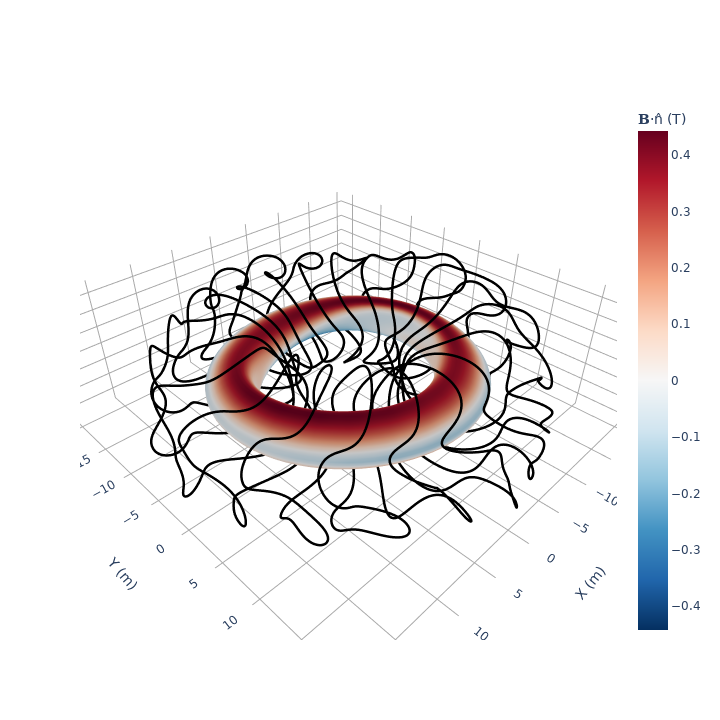

In [23]:
## visualize the optimized coilset and the normal field error
# passing in eq.surface avoids the unnecessary plasma field computation (as this is a vacuum eq)
fig = plot_3d(
    eq.surface, "B*n", field=optimized_coilset, field_grid=coil_grid, grid=plot_grid
)

fig = plot_coils(optimized_coilset, fig=fig)
fig.show()

In [24]:
optimized_coilset.save("re_optimized_coilset_n11.h5")

In [25]:
optimized_coilset = load("re_optimized_coilset_n11.h5")

In [26]:
from desc.magnetic_fields import FourierCurrentPotentialField

In [41]:
eq = load("desc_initial_fixed_bdry_solve_final.h5")

In [ ]:
# just do sheet current opt first, to get bdry field jump lower
eq.surface = FourierCurrentPotentialField.from_surface(eq.surface,M_Phi=2,N_Phi=2)

# define our objective function
obj = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field=optimized_coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            field_fixed=True
        ),
    )
)

constraints = (FixPsi(eq),
               FixCurrent(eq),
               FixPressure(eq),
               ForceBalance(eq),
              FixBoundaryR(eq),
              FixBoundaryZ(eq)) # force balance in the constraints bc the equilibrium is there


optimizer = Optimizer("proximal-lsq-exact")
for k in np.arange(2,11,2):
    eq.surface.change_Phi_resolution(M=k,N=k)
    obj = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field=optimized_coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            field_fixed=True
        ),
    )
)

    constraints = (FixPsi(eq),
                   FixCurrent(eq),
                   FixPressure(eq),
                   ForceBalance(eq),
                  ) # force balance in the constraints bc the equilibrium is there
    # get modes where |m|, |n| > k
    R_modes = eq.surface.R_basis.modes[
        np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
    ]
    Z_modes = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]

    # fix those modes
    bdry_constraints = (
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
    )
    (eq,), _ = optimizer.optimize(
        (eq,),
        objective=obj,
        constraints=constraints+bdry_constraints,
        maxiter=75,
        ftol=1e-3,
        verbose=3,
        # copy=True,
    )
    eq.save("re_solved_free_bdry_with_re_opt_coils_K.h5")
    Bn,_ = optimized_coilset.compute_Bnormal(eq)
    print(np.max(Bn))

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 222 ms
Timer: Objective build = 252 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 136 ms
Timer: Objective build = 157 ms
Timer: Proximal projection build = 5.04 sec
Building objective: fixed Psi
Building objective: fixed current
Building objective: fixed pressure
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 201 ms
Timer: Linear constraint projection build = 1.09 sec
Number of parameters: 39
Number of objectives: 15123
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.934e+01                                    1.952e+01   
       1              2          3.947e+01      1.987e+01      5.033e+07      9.834e+00   
       2              3          1.380e+01      2.567e+01      1.151e+08      4.867e

In [37]:
normalized_field = compute_average_normalized_field(optimized_coilset, eq, vacuum=False)
print(f"<Bn> = {normalized_field:.3e}")


<Bn> = 4.167e-03


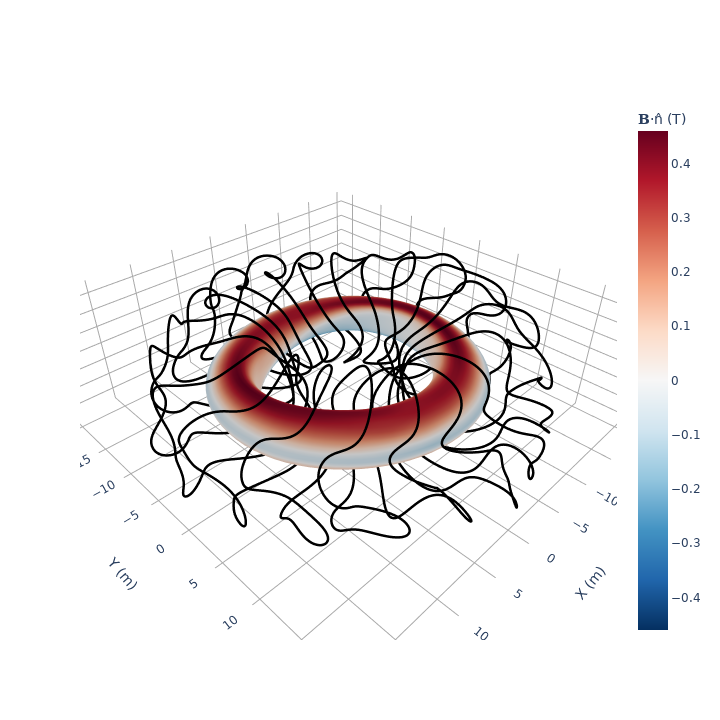

In [38]:
## visualize the optimized coilset and the normal field error
# passing in eq.surface avoids the unnecessary plasma field computation (as this is a vacuum eq)
fig = plot_3d(
    eq.surface, "B*n", field=optimized_coilset, field_grid=coil_grid, grid=plot_grid
)

fig = plot_coils(optimized_coilset, fig=fig)
fig.show()

In [39]:
Bn,_ = optimized_coilset.compute_Bnormal(eq)
print(np.max(Bn))

0.06937925338864709


In [27]:
## it is a good idea to re-solve  the free bdry problem after the single stage to ensure
## the equilibrium is consistent with the coilset found
# coil_grid = LinearGrid(N=40)
# # similarly define a grid on the plasma surface where B*n errors will be evaluated
# plasma_grid = LinearGrid(M=30, N=20, NFP=eq.NFP, sym=False)

eq.surface = FourierCurrentPotentialField.from_surface(eq.surface,M_Phi=2,N_Phi=2)

# define our objective function
obj = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field=optimized_coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            field_fixed=True
        ),
    )
)

constraints = (FixPsi(eq),
               FixCurrent(eq),
               FixPressure(eq),
               ForceBalance(eq)) # force balance in the constraints bc the equilibrium is there


optimizer = Optimizer("proximal-lsq-exact")
for k in np.arange(2,11,2):
    obj = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field=optimized_coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            field_fixed=True
        ),
    )
)

    constraints = (FixPsi(eq),
                   FixCurrent(eq),
                   FixPressure(eq),
                   ForceBalance(eq)) # force balance in the constraints bc the equilibrium is there

    (eq,), _ = optimizer.optimize(
        (eq,),
        objective=obj,
        constraints=constraints,
        maxiter=40,
        ftol=1e-3,
        verbose=3,
        # copy=True,
    )
    eq.save("re_solved_free_bdry_with_re_opt_coils.h5")

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 478 ms
Timer: Objective build = 614 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.20 sec
Timer: Objective build = 1.27 sec
Timer: Proximal projection build = 12.7 sec
Building objective: fixed Psi
Building objective: fixed current
Building objective: fixed pressure
Timer: Objective build = 313 ms
Timer: Linear constraint projection build = 2.62 sec
Number of parameters: 455
Number of objectives: 15123
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.934e+01                                    1.952e+01   
       1              3          5.373e+01      5.606e+00      1.207e+07      1.632e+01   
       2              4          4.386e+01      9.875e+00      2.569e+07      1.167e+01   
       3              5          2.856e+01

KeyboardInterrupt: 

In [ ]:
normalized_field = compute_average_normalized_field(optimized_coilset, eq, vacuum=False)
print(f"<Bn> = {normalized_field:.3e}")

In [ ]:
plot_surfaces(eq)

In [ ]:
## visualize the optimized coilset and the normal field error
# passing in eq.surface avoids the unnecessary plasma field computation (as this is a vacuum eq)
fig = plot_3d(
    eq, "B*n", field=optimized_coilset, field_grid=coil_grid, grid=plot_grid
)

fig = plot_coils(optimized_coilset, fig=fig)
fig.show()

In [ ]:
# plot_field_lines(optimized_coilset, optimized_eq);

In [ ]:
eq_init = load("desc_initial_fixed_bdry_solve_final.h5")

In [ ]:
from desc.plotting import *
plot_comparison([eq,eq_init])

In [46]:
eq = eq_init

In [50]:
## it is a good idea to re-solve  the free bdry problem after the single stage to ensure
## the equilibrium is consistent with the coilset found
# coil_grid = LinearGrid(N=40)
# # similarly define a grid on the plasma surface where B*n errors will be evaluated
# plasma_grid = LinearGrid(M=30, N=20, NFP=eq.NFP, sym=False)

eq.surface = FourierCurrentPotentialField.from_surface(eq.surface,M_Phi=2,N_Phi=2)

# define our objective function
obj = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field=optimized_coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            field_fixed=True
        ),
    )
)

constraints = (FixPsi(eq),
               FixCurrent(eq),
               FixPressure(eq),
               ForceBalance(eq)) # force balance in the constraints bc the equilibrium is there


optimizer = Optimizer("lsq-exact")
for k in np.arange(2,11,2):
    obj = ObjectiveFunction(
    (
        BoundaryError(
            eq,
            field=optimized_coilset,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            field_fixed=False
        ),
    )
)

    constraints = (FixPsi(eq),
                   FixCurrent(eq),
                   FixPressure(eq),
                   # ForceBalance(eq),
                  FixBoundaryR(eq),
                  FixBoundaryZ(eq),
                   FixParameters(eq),
                  FixParameters(optimized_coilset,{"X_n":True,"Y_n":True,"Z_n":True})) # force balance in the constraints bc the equilibrium is there

    (eq,optimized_coilset), _ = optimizer.optimize(
        (eq,optimized_coilset),
        objective=obj,
        constraints=constraints,
        maxiter=40,
        ftol=1e-3,
        verbose=3,
        # copy=True,
    )
    # eq.save("re_solved_free_bdry_with_re_opt_coils.h5")

Building objective: Boundary error
Precomputing transforms
Timer: Precomputing transforms = 215 ms
Timer: Objective build = 491 ms
Building objective: fixed Psi
Building objective: fixed current
Building objective: fixed pressure
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed parameters
Building objective: fixed parameters
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Building objective: fixed shift
Building objective: fixed rotation
Timer: Objective build = 3.09 sec
Timer: Linear constraint projection build = 4.41 sec
Number of parameters: 5
Number of objectives: 15123
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          6.812e+01                                    7.944e-07   
       1 

KeyboardInterrupt: 

In [51]:
optimized_coilset.save("re_optimized_coilset_n11_with_currents_optimized.h5")

In [52]:
normalized_field = compute_average_normalized_field(optimized_coilset, eq, vacuum=False)
print(f"<Bn> = {normalized_field:.3e}")

<Bn> = 6.381e-02


In [53]:
## visualize the optimized coilset and the normal field error
# passing in eq.surface avoids the unnecessary plasma field computation (as this is a vacuum eq)
fig = plot_3d(
    eq, "B*n", field=optimized_coilset, field_grid=coil_grid, grid=plot_grid
)

fig = plot_coils(optimized_coilset, fig=fig)
fig.show()

AssertionError: grid must be LinearGrid for 3d plotting